# Workflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import mammos_analysis
import mammos_dft
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

## 1: DFT data: magnetisation and anisotropy at zero Kelvin

In [2]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Nd2Fe14B-136")

Found material in database.

Chemical Formula: Nd2Fe14B
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom
ICSD_label: 
OQMD_label:

The first step loads spontaneous magnetisation $M_s$ and the uniaxial anisotropy constant $K_1$ from a database of DFT calculations.

In [3]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1280000.0, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3))

In [4]:
results_dft.Ms_0

SpontaneousMagnetization(value=1280000.0, unit=A / m)

In [5]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3)

## 2: Temperature-dependent magnetisation data from spindynamics database lookup

In [6]:
magnetisation_data = mammos_spindynamics.db.get_spontaneous_magnetisation("Co2Fe2H4-194")

In the second step we use a spin dynamics calculation database. We load some points for the temperature-dependent magnetisation.

In [7]:
magnetisation_data.dataframe

,T[K],M[A/m]
0,0,1.190240e+06
1,20,1.160762e+06
2,40,1.152765e+06
3,60,1.144332e+06
4,80,1.136095e+06
...,...,...
76,1520,7.129165e+03
77,1540,6.674613e+03
78,1560,6.599177e+03
79,1580,6.616132e+03


In [8]:
magnetisation_data.T

ThermodynamicTemperature(value=[   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.
  240.  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.
  480.  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.
  720.  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.
  960.  980. 1000. 1020. 1040. 1060. 1080. 1100. 1120. 1140. 1160. 1180.
 1200. 1220. 1240. 1260. 1280. 1300. 1320. 1340. 1360. 1380. 1400. 1420.
 1440. 1460. 1480. 1500. 1520. 1540. 1560. 1580. 1600.], unit=K)

In [9]:
magnetisation_data.Ms

SpontaneousMagnetization(value=[1190240.2412648  1160762.15152728 1152764.540031   1144332.38021977
 1136095.4237953  1128134.37709324 1119860.36127139 1111776.43793683
 1102918.50364088 1094392.01798628 1085670.06372291 1076778.81897829
 1067425.28513189 1057970.97409635 1048538.21055569 1039913.8221449
 1029517.07701433 1019718.19960104 1010212.40682623 1000827.01766803
  990071.55620798  977847.7971226   967365.03404838  957943.74673504
  945368.08824221  933306.33678552  924042.80638082  911156.5370935
  898923.20851189  886959.86875088  874610.18656417  859777.5032481
  846674.7339648   833341.85234593  817215.36597138  802915.55664802
  788770.83767705  767322.55015624  749504.37038855  733715.25355713
  716555.57268794  695546.66554008  675931.69422208  650394.96667178
  623964.15571257  595267.15471822  574337.71381396  540677.01870906
  506480.06838947  465749.37929254  419581.94398809  363556.9147052
  283780.87532889  116330.7659029    45920.08375439   28204.38382936
   2225

## 3: Calculate micromagnetic intrinsic properties using Kuz'min formula

In [10]:
kuzmin_result = mammos_analysis.kuzmin(
    T=magnetisation_data.T,
    Ms=magnetisation_data.Ms,
    K1_0=results_dft.K1_0
)

In [11]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), K1=K1(T))

In [12]:
kuzmin_result.A, type(kuzmin_result.A)

(A(T), mammos_analysis.kuzmin._A_function_of_temperature)

In [13]:
kuzmin_result.K1, type(kuzmin_result.K1)

(K1(T), mammos_analysis.kuzmin._K1_function_of_temperature)

In [14]:
kuzmin_result.Ms, type(kuzmin_result.Ms)

(Ms(T), mammos_analysis.kuzmin._Ms_function_of_temperature)

In [15]:
T = me.Entity("ThermodynamicTemperature", value=300, unit="K")
T

ThermodynamicTemperature(value=300.0, unit=K)

In [16]:
kuzmin_result.Ms(T), type(kuzmin_result.Ms(T))

(SpontaneousMagnetization(value=1083200.0171988958, unit=A / m),
 mammos_entity.base.Entity)

## 4: Run micromagnetic simulation - Evaluate hysteresis loop

In [18]:
loop_results = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=kuzmin_result.Ms(T),
    A=kuzmin_result.A(T),
    K1=kuzmin_result.K1(T),
    hstart=(7*u.T).to(u.A / u.m, equivalencies=u.magnetic_flux_field()),
    hfinal=(-10*u.T).to(u.A / u.m, equivalencies=u.magnetic_flux_field()),
    hnsteps=30,
)

The outputs from the hysteresis loop are:

In [19]:
loop_results.dataframe

,idx,mu0_Hext,polarisation,E
0,1,7.000000,1.361046,-1.059314e+07
1,1,6.433333,1.361033,-9.979396e+06
2,1,5.866667,1.361018,-9.365656e+06
3,1,5.300000,1.361001,-8.751924e+06
4,1,4.733333,1.360982,-8.138200e+06
5,1,4.166667,1.360959,-7.524485e+06
6,1,3.600000,1.360933,-6.910781e+06
7,1,3.033333,1.360901,-6.297090e+06
8,1,2.466667,1.360863,-5.683415e+06
9,1,1.900000,1.360817,-5.069759e+06


In [20]:
loop_results.H

ExternalMagneticField(value=[ 5570423.00518393  5119484.00000238  4668544.99482082  4217605.98963926
  3766666.98445771  3315727.97927615  2864788.9740946   2413849.96891304
  1962910.96373148  1511971.95854993  1061032.95336837   610093.94818681
   159154.94300526  -291784.0621763   -742723.06735786 -1193662.07253941
 -1644601.07772097 -2095540.08290253 -2546479.08808408 -2997418.09326564
 -3448357.09844719 -3899296.10362875 -4350235.10881031], unit=A / m)

In [21]:
loop_results.M

SpontaneousMagnetization(value=[ 1.36104574  1.36103288  1.36101819  1.36100133  1.36098185  1.36095916
  1.36093251  1.36090094  1.36086315  1.36081737  1.36076117  1.36069114
  1.36060228  1.36048715  1.36033418  1.3601246   1.35982617  1.35937954
  1.35866451  1.35740223  1.35478639  1.34702993 -1.36100654], unit=T)

In [22]:
loop_results.EnergyDensity

EnergyDensity(value=[-10593141.70038446  -9979395.92495052  -9365656.34957104
  -8751923.87099064  -8138199.56807237  -7524484.75060708
  -6910781.02475024  -6297090.382104    -5683415.32307882
  -5069759.03102617  -4456125.62340659  -3842520.52307765
  -3228951.02286315  -2615427.17264795  -2001963.22815391
  -1388580.12923425   -775309.98666853   -162204.8069432
    450644.87586112   1063064.67175376   1674661.48979254
   2284228.73940302  -8932432.62706742], unit=J / m3)

We can generate a table in Tesla:

In [25]:
import pandas as pd

u.set_enabled_equivalencies(u.magnetic_flux_field())
pd.DataFrame(
    {
        "mu0_H": loop_results.H.to(u.T),
        "J": loop_results.M.to(u.T),
        "EnergyDensity": loop_results.EnergyDensity,
    }
).head(10)

,mu0_H,J,EnergyDensity
0,7.000000,1.361046,-1.059314e+07
1,6.433333,1.361033,-9.979396e+06
2,5.866667,1.361018,-9.365656e+06
3,5.300000,1.361001,-8.751924e+06
4,4.733333,1.360982,-8.138200e+06
5,4.166667,1.360959,-7.524485e+06
6,3.600000,1.360933,-6.910781e+06
7,3.033333,1.360901,-6.297090e+06
8,2.466667,1.360863,-5.683415e+06
9,1.900000,1.360817,-5.069759e+06


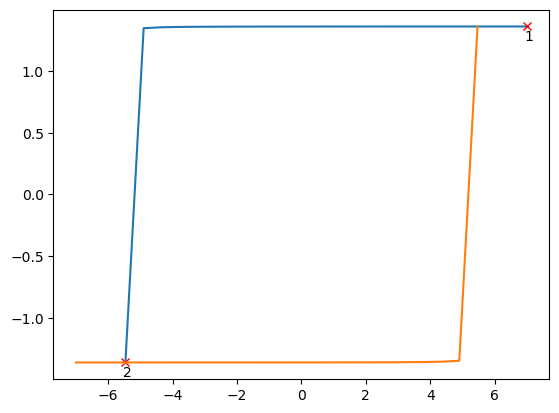

In [26]:
loop_results.plot(configuration_marks=True)

In [27]:
loop_results.configurations

[PosixPath('/home/petrocch/Seafile/programming/mammos/workflow/8/hystloop/hystloop_0001.vtu'),
 PosixPath('/home/petrocch/Seafile/programming/mammos/workflow/8/hystloop/hystloop_0002.vtu')]

In [28]:
loop_results.plot_configuration(0)

Widget(value='<iframe src="http://localhost:45667/index.html?ui=P_0x7fd12bb003d0_0&reconnect=auto" class="pyvi…

We can extract the extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [29]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    loop_results.M,
    loop_results.H
)

In [30]:
extrinsic_properties.Hc

CoercivityHcExternal(value=-1082641.2760667547, unit=A / m)

In [31]:
extrinsic_properties.Mr

Remanence(value=-4350235.108810307, unit=A / m)

In [32]:
extrinsic_properties.BHmax

MaximumEnergyProduct(value=0.0, unit=J / m3)